In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

#import time
#import wandb

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load les données

fichier = open('villes.txt')
donnees = fichier.read()
villes = donnees.replace('\n', ',').split(',')
villes = [ville for ville in villes if len(ville) > 2]
villes = sorted(villes, key=len)

In [4]:
# création du vocabulaire

vocabulaire = sorted(list(set(''.join(villes))))
vocabulaire = ["<pad>", "<SOS>", "<EOS>"] + vocabulaire

# pour convertir char <-> int
char_to_int = {}
int_to_char = {}

for (c, i) in zip(vocabulaire, range(len(vocabulaire))):
    char_to_int[c] = i
    int_to_char[i] = c

In [5]:
num_sequences = len(villes)
max_len = max([len(ville) for ville in villes]) + 2 # account for <SOS> and <EOS>, which are appened at the beg. and end of each seq

X = torch.zeros((num_sequences, max_len), dtype=torch.int32)

for i in range(num_sequences):
    X[i] = torch.tensor([char_to_int['<SOS>']] + [char_to_int[c] for c in villes[i]] + [char_to_int['<EOS>']] + [char_to_int['<pad>']] * (max_len - len(villes[i]) - 2))

n_split = int(0.9*X.shape[0])

idx_permut = torch.randperm(X.shape[0])
idx_train, _ = torch.sort(idx_permut[:n_split])
idx_val, _ = torch.sort(idx_permut[n_split:])

X_train = X[idx_train]
X_val = X[idx_val]

In [6]:
def get_batch(split, batch_size):
    # returns a batch, according to the data pipeline written in the W&B report
    data = X_train if split == 'train' else X_val

    idx_seed = torch.randint(high=data.shape[0], size=(1,), dtype=torch.int32).item() #sample la ligne seed autour de laquelle on va piocher les exemples

    if split == 'train':
        idx = torch.randint(low = max(0, idx_seed - 4 * batch_size), high = min(data.shape[0], idx_seed + 4 * batch_size), size=(batch_size,), dtype=torch.int32) #samples les indices du batch à produire
        
    else:
        start = max(0, idx_seed-batch_size/2)
        end =  min(data.shape[0]-1, idx_seed+batch_size/2)

        if end-start != batch_size:
            if start == 0:
                end = end - (idx_seed-batch_size/2 - start)
            else:
                start = start - (idx_seed+batch_size/2 - end)

        start, end = int(start), int(end)

        idx = torch.arange(start=start, end=end, dtype=torch.int64)
        
    #pq 4 ? bon compromis entre assez large pour pas bcp de répétitions, assez petit pour pas bcp de padding (cf data.ipynb)
    #en moyenne sur un batch, 6.7 d'écart en max_len et min_len (donc en moyenne pour une séq., 3,3 de padding) (ça fait bcp finalement? a comparer devant la longueur d'un mot) et max_len 17.8
    #longueur moyenne d'une séq. : 11.6. donc en moyenne pour une séq., on rajoute 28% de compute inutile...
    #on aura forcement pas mal de padding sur le val car dataset comparable devant 4*batch_size

    #pour 2, on aura 3.5 d'écart, donc 1.7 de padding
    # donc 14% de compute inutile par mot

    #pour 2, on a 12% des exemples qui sont des répétitions (122 pour un batch de 1024, en moyenne)
    #pour 4, seulement 6% (67 exemples)

    #pour batch_size=512
    #pour 2, 5% de répétitions, 1.8 de disp. donc 0.9 de padding (soit 7% de compute inutile par séq.)
    #pour 4, 3% de répétitions, 3.5 de disp. donc 1.7 de padding (soit 14% de compute inutile par séq.)

    #pour privilégier des données iid, je choisi de partir sur 4 (pour avoir des batch diversifiés, au détriment d'un peu de compute inutile)
    #voir considérer plus ?
    
    #pour le val. set, 4 semble bcp trop
    #pour 4, 12% de répétitions, 15 de disp. donc 7 de padding (soit plus de 50% de compute lost)
    #c'est dommage, vu qu'avoir des batchs diversifiés n'a aucun interet pour le calcul du loss, donc on ne fait que perdre du compute
    #mais le pb avec 1 (par exemple) c'est qu'on a enormément de répétitions (25%) au sein d'un batch... donc estimation du cout totalement erronée
    #je choisis d'adopter une stratégie un peu différente: sample idx_seed, et on prends tous les index entre idx_seed-batch_size/2 et idx_seed+batch_size/2

    idx_sorted, _ = torch.sort(idx) #on les ordonne pour recuperer facilement la longueur de la plus grande seq. du batch

    X_batch = data[idx_sorted] #on extrait la matrice qui va produire Xb et Yb

    max_len_batch = torch.sum(torch.ne(X_batch[-1], char_to_int['<pad>'])) #longueur de la plus grande seq. du batch : torch.ne(X_batch[-1], 0) crée une matrice masque, avec True si diff de 0, False si egal a 0

    Xb = X_batch[:, :max_len_batch-1] #on selectionne que jusqu'a la len max - 1 (<EOS> du plus long inutile) (le reste n'est que padding)
    Yb = X_batch[:, 1:max_len_batch] #meme que Xb, mais décalé de 1 (avec le <EOS> mais sans le <SOS>)

    #Xb[Xb == 1] = -1 #on remplace le <EOS> par du padding (totalement optionnel)

    Xb = Xb.pin_memory().to('cuda', non_blocking=True)
    Yb = Yb.type(torch.LongTensor).pin_memory().to('cuda', non_blocking=True)
    #Yb = Yb.type(torch.LongTensor)

    return Xb, Yb

#todo: mettre les shapes a cote

In [7]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, d_query):
        super().__init__()

        self.d_query = d_query

        self.X_to_query = nn.Linear(d_model, self.d_query, bias=False)
        self.X_to_key = nn.Linear(d_model, self.d_query, bias=False)
        self.X_to_value = nn.Linear(d_model, d_model, bias=False)

    def forward(self, X):
        # X : (B, T, embed_dim), targets: (B, T)

        B, T, _ = X.size()

        Q = self.X_to_query(X) # (B, T, d_query)
        K = self.X_to_key(X) # (B, T, d_key=d_query)
        V = self.X_to_value(X) # (B, T, d_value)

        QK_T = Q @ torch.transpose(K, 1, 2) # (B, T, T)

        mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
        QK_T[:, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T / math.sqrt(self.d_query), dim=2) # (B, T, T)
        attention = attention_scores @ V # (B, T, d_value=d_head)

        return attention
    
class SelfAttentionMultiHead(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.X_to_query = nn.Linear(d_model, self.n_heads*self.d_head, bias=False) # d_query = d_head as in the Transformer paper
        self.X_to_key = nn.Linear(d_model, self.n_heads*self.d_head, bias=False)
        self.X_to_value = nn.Linear(d_model, self.n_heads*self.d_head, bias=False)

    def forward(self, X):
        # X : (B, T, d_model), targets: (B, T)

        B, T, _ = X.size()

        Q = self.X_to_query(X).view(B, T, self.n_heads, self.d_head).transpose(1, 2) # (B, n_heads, T, d_query)
        K = self.X_to_key(X).view(B, T, self.n_heads, self.d_head).transpose(1, 2) # (B, n_heads, T, d_key)
        V = self.X_to_value(X).view(B, T, self.n_heads, self.d_head).transpose(1, 2) # (B, n_heads, T, d_head=d_value)

        QK_T = Q @ torch.transpose(K, 2, 3) # (B, n_h, T, T)

        mask = torch.tril(torch.ones((T, T), dtype=torch.int32)).bool()
        QK_T[:, :, ~mask] = -float("inf")

        attention_scores = torch.softmax(QK_T / math.sqrt(self.d_head), dim=3) # (B, n_h, T, T)
        attention = attention_scores @ V # (B, n_h, T, d_value=d_head)

        attention = attention.transpose(1, 2) # (B, T, n_h, d_head)
        attention = attention.contiguous().view(B, T, self.n_heads*self.d_head) # n_heads*d_head = d_model

        return attention
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        #self.sa = SelfAttention(d_model, XX)
        self.sa = SelfAttentionMultiHead(d_model, n_heads)
        self.l1 = nn.LayerNorm(d_model)
        self.fc1 = nn.Linear(d_model, 4*d_model)
        self.act = F.selu # F.gelu # selu used in GPT-2/3, gelu is new
        self.fc2 = nn.Linear(4 * d_model, d_model)
        self.l2 = nn.LayerNorm(d_model)

    def forward(self, X): # (B, T, d_model)
        H = self.l1(X + self.sa(X)) #sublayer 1 = SA
        H = self.l2(H + self.fc2(self.act(self.fc1(H)))) #sublayer 2 = FC
        return H
    
class Transformer_LM(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, vocab_size):
        super().__init__()

        embed_dim = d_model
        
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        max_len=60
        self.PE = nn.Parameter(torch.randn(max_len, embed_dim)/10)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads) for _ in range(n_layers)])

        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, W, targets=None):
        # W : (B, T), targets: (B, T)

        B, T = W.size()

        X = self.embed(W) # (B, T, embed_dim=d_model)
        X = X + self.PE[:T]

        H = X
        for layer in self.layers:
            H = layer(H) # (B, T, d_model)
        
        logits = self.lm_head(H) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=0)

        return logits, loss
    
    def sample(self, prompt='', max_new_tokens=None):
        init_len = len(prompt)+1

        #convert prompt to (1, T) input tensor W
        W = torch.zeros(size=(1, init_len), dtype=torch.int64, device=device) # <SOS>

        W[0, 0] = 1 # <SOS> token
        for i, ch in enumerate(prompt):
            W[0, i+1] = char_to_int[ch]

        # autoregressive gen
        while True:
            B, T = W.size()
            
            X = self.embed(W)
            X = X + self.PE[:T]

            H = X
            for layer in self.layers:
                H = layer(H) # (B, T, d_model)

            logits = self.lm_head(H) # (1, T, vocab_size)
            probs = F.softmax(logits[:, -1], dim=1)

            next_token = torch.multinomial(probs, num_samples=1, replacement=True).item()
            next_char = int_to_char[next_token]

            if next_char == '<EOS>':
                break
                
            prompt += next_char

            if len(prompt)-init_len+1 == max_new_tokens or T == max_len:
                break

            W = torch.cat([W, torch.tensor(next_token, device=device, dtype=torch.int64).view(1, 1)], dim=1)

        return prompt

In [8]:
model = Transformer_LM(n_layers=8, n_heads=8, d_model=512, vocab_size=61)

In [10]:
sum([p.numel() for p in model.parameters()])

23198781

In [111]:
lossi = []

lr = 2e-3
lr_min = 2e-4 # lr/10 as is chinchilla
lr_warmup_iter = 0
lr_decay_iter = 10000 # max_iters as in chinchilla

batch_size = 256
n_layers = 3
d_model = 64
n_heads = 4

eval_interval = 50
eval_iter = 50

config = {
               "log_learning_rate": np.log(lr),
               "lr_warmup_iter": lr_warmup_iter,
               "lr_decay_iter": lr_decay_iter,
               "batch_size": batch_size,
               "n_layers": n_layers,
               "d_model": d_model,
               "n_heads": n_heads,
               "act": 'selu',
               "optimizer": "AdamW",
               "architecture": "Transformer"
        }

wandb.init(project="blablateurbinaire", config=config)
iter_num = 0

In [112]:
model = Transformer_LM(n_layers=n_layers, d_model=d_model, n_heads=n_heads).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=lr)

In [113]:
total_params = sum(p.numel() for p in model.parameters())
total_params

145838

In [114]:
# cosine with warmup (taken from @karpathy)
def get_lr(it):
    if lr_decay_iter == 0:
        return lr
    
    # 1) linear warmup for warmup_iters steps
    if it < lr_warmup_iter:
        return lr * it / lr_warmup_iter
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iter:
        return lr_min
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - lr_warmup_iter) / (lr_decay_iter - lr_warmup_iter)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))  # coeff ranges 0..1
    return lr_min + coeff * (lr - lr_min)

In [115]:
""" LR finder gives a really low lr of approx. 8e-5. 2e-3 is at the center of the bottom
lr  = 1e-8

for param_group in optim.param_groups:
        param_group['lr'] = lr
"""

In [116]:
start_time = time.time()
N = 10000
iter_num_start = iter_num

while iter_num < iter_num_start+N:
    #lr = 1.01 * lr

    Xb, Yb = get_batch('train', batch_size)

    logits, loss = model(Xb, Yb)
    lossi.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

    # eval : track loss (train & val), update_to_data
    if iter_num % eval_interval == 0:
        to_log = {}

        with torch.no_grad():
            model.eval()
            for split in ['train', 'val']:
                loss_mean = 0
                for i in range(eval_iter):
                    Xb, Yb = get_batch(split, batch_size)
                    logits, loss = model(Xb, Yb)
                    loss_mean += loss.item()

                loss_mean /= eval_iter
                to_log["loss_" + split] = loss_mean
            model.train()
        
        wandb.log(to_log | {"lr": get_lr(iter_num)}, step=iter_num)

    for param_group in optim.param_groups:
        param_group['lr'] = get_lr(iter_num)

    iter_num += 1

end_time = time.time()
num_examples_processed = N * batch_size

print("training throughput = {} examples/s".format(str(num_examples_processed/(end_time-start_time))))

training throughput = 112827.32918019821 examples/s


In [117]:
wandb.log({"training_throughput": num_examples_processed/(end_time-start_time)})
wandb.log({"params_num": sum([p.numel() for p in model.parameters()])})
wandb.finish()

loss_train,█████████████▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▂▁▂▄▄▄▇
loss_val,█████████████▇▇▆▅▄▄▃▂▂▁▁▁▁▁▁▁▂▂▄▄▄▇
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅█
params_num,▁
training_throughput,▁
loss_train,3.63571
loss_val,3.68204
lr,0.22421
params_num,145838
training_throughput,112827.32918


In [71]:
for _ in range(10):
    print(model.sample())

courtenac
auze
cardé
valffloba
nouvezon
courpont
brousse-sous
guilly-lis-caousse
lacourt
tarde-les-misson


In [82]:
from losscape.create_landscape import create_2D_losscape, create_3D_losscape

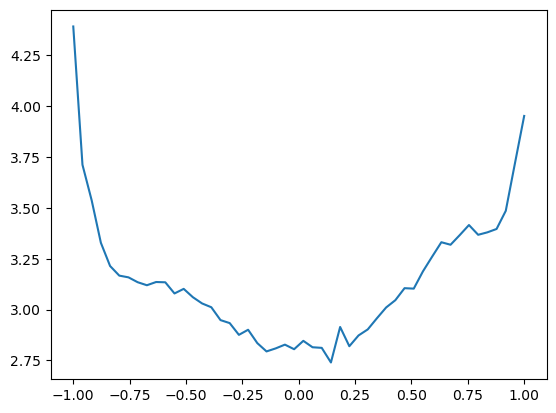

<Figure size 640x480 with 0 Axes>

In [84]:
X, losses = create_2D_losscape(model, get_batch=get_batch)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


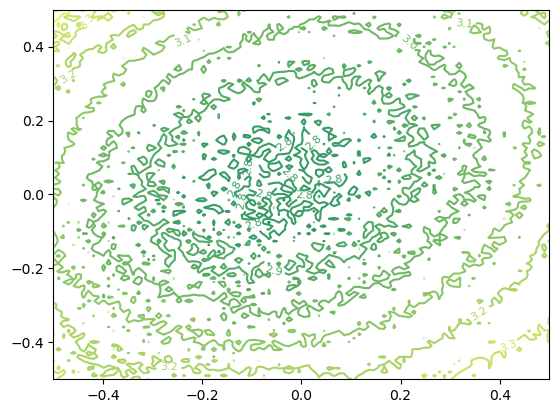

Here's your output file:losscape_log.vtp
number_points = 10000 points
matrix_size = 100 x 100
poly_size = 99 x 99
number_polys = 9801
Done with file:losscape_log.vtp
Here's your output file:losscape.vtp
number_points = 10000 points
matrix_size = 100 x 100
poly_size = 99 x 99
number_polys = 9801
Done with file:losscape.vtp


<Figure size 640x480 with 0 Axes>

In [83]:
X, Y, losses = create_3D_losscape(model, get_batch=get_batch, num_batches=10, num_points=100, output_vtp=True, x_min=-0.5, x_max=0.5, y_min=-0.5, y_max=0.5)

In [41]:
losses

array([[ 3.42139256,  3.41222954,  3.47096753, ...,  3.08790863,
         3.06346095,  3.06966829],
       [ 3.57993209,  3.45590961,  3.31783211, ...,  3.05978942,
         3.06527781,  3.09023595],
       [ 3.81902397,  3.27479172,  3.65264177, ...,  3.06037104,
         3.08424819,  3.11108458],
       ...,
       [24.29110718, 20.95235825, 14.70007896, ...,  3.81523883,
         4.27774274,  3.69545734],
       [21.9875946 , 18.02406025, 18.34983397, ...,  3.72872365,
         3.87391663,  5.47629237],
       [23.17934418, 17.3145752 , 19.06894684, ...,  3.86264038,
         4.25823545,  5.26807535]])

In [1]:
import numpy as np

In [6]:
np.finfo(np.single).max

3.4028235e+38